In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Found 4495 files belonging to 12 classes.
Using 3596 files for training.
Found 4495 files belonging to 12 classes.
Using 899 files for validation.
Found 1499 files belonging to 12 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 826s 7s/step - accuracy: 0.5375 - loss: 15.8657 - val_accuracy: 0.7697 - val_loss: 2.4886
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.7737 - loss: 2.4037 - val_accuracy: 0.7864 - val_loss: 1.3330
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.8023 - loss: 1.1768 - val_accuracy: 0.8398 - val_loss: 0.9534
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8221 - loss: 0.8783 - val_accuracy: 0.8120 - val_loss: 1.0197
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8429 - loss: 0.7177 - val_accuracy: 0.8409 - val_loss: 0.8074
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.8413 - loss: 0.7024 - val_accuracy: 0.8187 - v

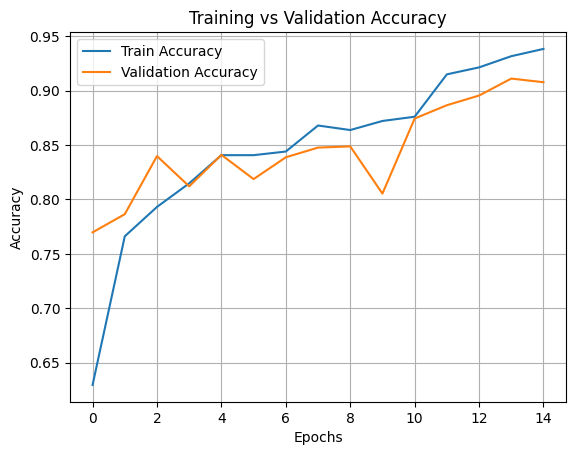

47/47 ━━━━━━━━━━━━━━━━━━━━ 276s 6s/step - accuracy: 0.9312 - loss: 0.3258
Test accuracy: 0.9093


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input

# --- 1. Load Datasets ---
# This part is correct, no changes needed here.
training_set = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Dataset_Crops/train1",
    labels="inferred",
    label_mode="categorical",
    image_size=(128,128),
    batch_size=32,
    seed=42,
    validation_split=0.2,
    subset="training",
    shuffle=True
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Dataset_Crops/train1",
    labels="inferred",
    label_mode="categorical",
    image_size=(128,128),
    seed=42,
    validation_split=0.2,
    subset="validation",
    batch_size=32,
    shuffle=True
)

test_set = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Dataset_Crops/test1",
    labels="inferred",
    label_mode="categorical",
    image_size=(128,128),
    batch_size=32,
    shuffle=False
)

# --- 2. Preprocess Datasets ---
# Define a function to apply VGG16-specific preprocessing.
def vgg_preprocess(image, label):
    image = preprocess_input(image)
    return image, label

# Apply the preprocessing function to all datasets.
train_ds = training_set.map(vgg_preprocess)
val_ds = validation_set.map(vgg_preprocess)
test_ds = test_set.map(vgg_preprocess)

# Improve performance with caching & prefetching.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# --- 3. Build the Model ---
# Define the data augmentation layers.
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
], name="data_augmentation")

# Load pre-trained VGG16 model without its top classification layers.
vgg_base = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Freeze the VGG16 layers to prevent them from being trained initially.
vgg_base.trainable = False

# Build the final model by combining data augmentation, VGG16, and new classification layers.
model = Sequential([
    Input(shape=(128,128, 3)),
    data_augmentation,
    vgg_base,
    Flatten(),
    Dense(1500, activation='relu'),
    Dropout(0.4),
    Dense(12, activation='softmax')
])

# --- 4. Initial Training (with frozen base) ---
# Compile the model for the first round of training.
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model.
initial_history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# --- 5. Fine-Tuning (with unfrozen layers) ---
# Unfreeze the base model to allow for fine-tuning.
vgg_base.trainable = True

# Recompile with a lower learning rate for fine-tuning.
model.compile(optimizer=Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training to fine-tune the model.
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,              # total epochs (10 initial + 5 fine-tune)
    initial_epoch=initial_history.epoch[-1] + 1
)


# --- 6. Evaluate the Model ---

def get_metric(history, keys):
    for k in keys:
        if k in history:
            return history[k]
    return []  # return empty list if not found

# Initial training
train_acc = get_metric(initial_history.history, ['accuracy', 'categorical_accuracy', 'acc'])
val_acc   = get_metric(initial_history.history, ['val_accuracy', 'val_categorical_accuracy', 'val_acc'])

# Fine-tuning (may be empty if no extra epochs ran)
fine_train_acc = get_metric(fine_tune_history.history, ['accuracy', 'categorical_accuracy', 'acc'])
fine_val_acc   = get_metric(fine_tune_history.history, ['val_accuracy', 'val_categorical_accuracy', 'val_acc'])

# Combine
all_train_acc = train_acc + fine_train_acc
all_val_acc   = val_acc + fine_val_acc

# Plot Accuracy
plt.plot(all_train_acc, label='Train Accuracy')
plt.plot(all_val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.grid(True)
plt.show()



# Evaluate the final model on the test set.
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.4f}')

# --- 7. Save the Model ---
model.save('trained_Crop_disease_model.keras')

from google.colab import files
files.download("trained_Crop_disease_model.keras")


Found 1499 files belonging to 12 classes.
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9180 - loss: 0.3897

✅ Test Accuracy: 0.9079
✅ Test Loss: 0.4482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


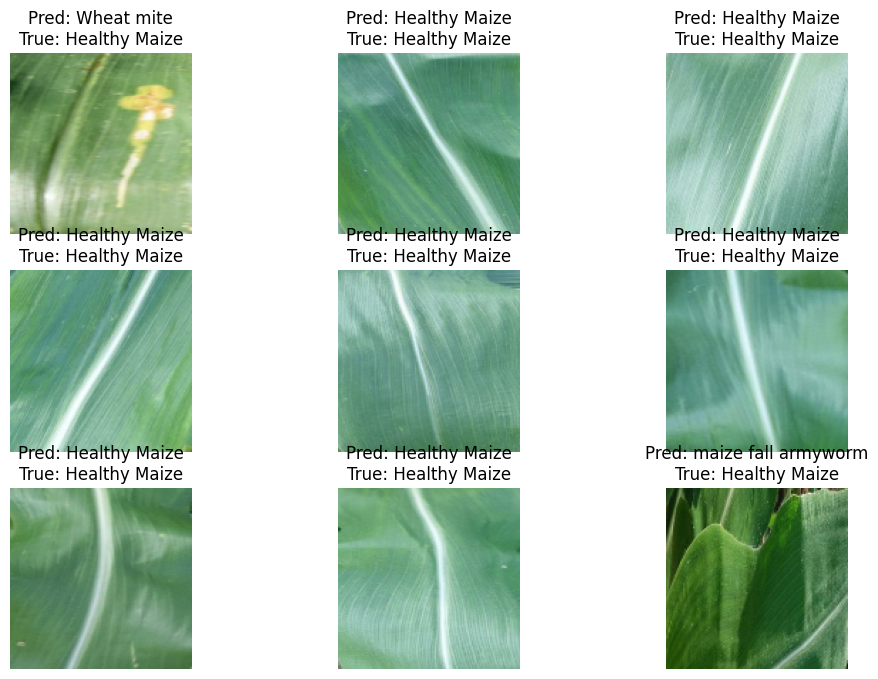

In [ ]:
#Testing Dataset
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input

# --- 1. Load Test Dataset ---
test_set = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Dataset_Crops/test1",
    labels="inferred",
    label_mode="categorical",
    image_size=(128,128),
    batch_size=32,
    shuffle=False
)

# Preprocess with VGG16 preprocessing
def vgg_preprocess(image, label):
    image = preprocess_input(image)
    return image, label

test_ds = test_set.map(vgg_preprocess)

# --- 2. Load Trained Model ---
model = tf.keras.models.load_model("trained_Crop_disease_model.keras")

# --- 3. Evaluate on Test Set ---
loss, acc = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {acc:.4f}")
print(f"✅ Test Loss: {loss:.4f}")

# --- 4. Make Predictions on Test Images ---
import numpy as np
import matplotlib.pyplot as plt
class_names = test_set.class_names

for images, labels in test_set.take(1):  # take one batch
    preds = model.predict(preprocess_input(images))
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    plt.figure(figsize=(12, 8))
    for i in range(min(9, len(images))):  # show first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[true_classes[i]]}")
        plt.axis("off")
    plt.show()


Class Names: ['Healthy Maize', 'Healthy Wheat', 'RedRot sugarcane', 'RedRust sugarcane', 'Sugarcane Healthy', 'Wheat Brown leaf Rust', 'Wheat black rust', 'Wheat mite', 'Yellow Rust Sugarcane', 'maize ear rot', 'maize fall armyworm', 'maize stem borer']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


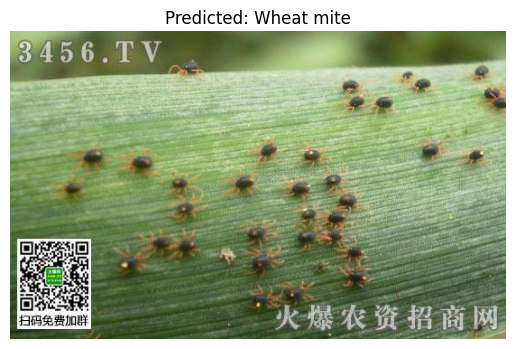

In [ ]:
#Testing model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

# --- 1. Load Model ---
model = tf.keras.models.load_model("trained_Crop_disease_model.keras")

# --- 2. Load Class Names (make sure same as training dataset) ---
dataset_dir = "/content/drive/MyDrive/Dataset_Crops/train1"
class_names = sorted(tf.io.gfile.listdir(dataset_dir))
print("Class Names:", class_names)

# --- 3. Load & Preprocess Test Image ---
img_path = "/content/drive/MyDrive/Dataset_Crops/test1/Wheat mite/24671.jpg"  # 👈 replace with one actual image path
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
img_array = preprocess_input(img_array)

# --- 4. Predict ---
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# --- 5. Show Result ---
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()
